# Imports

In [1]:
import os
import xml.etree.ElementTree as ET
import datetime
import string
import matplotlib.pyplot as plt
import tensorflow as tf

# For missing libraries, use following command:
# pip install -r src/requirements.txt

2025-06-23 13:02:02.575828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750676522.596793    6652 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750676522.603497    6652 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750676522.617991    6652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750676522.618014    6652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750676522.618016    6652 computation_placer.cc:177] computation placer alr

In [2]:
device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


I0000 00:00:1750676524.993491    6652 gpu_device.cc:2019] Created device /device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


# Graph tools

In [3]:
def plot_loss_and_time(loss, val_loss, total_time):
    epochs = range(1, len(loss) + 1)
    time_per_epoch = total_time / len(loss)
    time_per_epoch_list = [time_per_epoch.total_seconds()] * len(loss)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, loss, label='Training Loss', color='tab:blue', marker='o')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange', marker='x')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Set x-axis ticks to integer epoch values only
    ax1.set_xticks(epochs)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Enable minor grid lines
    ax1.minorticks_on()
    ax1.grid(which='both', linestyle=':', linewidth=0.5)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Time per Epoch (s)', color=color)
    ax2.plot(epochs, time_per_epoch_list, label='Time per Epoch', color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Loss and Time per Epoch')
    plt.show()

# Training Setup

## Environment

### Data source and training parameters

In [4]:
SOURCE = "labels_w"
'''Name of the dataset (used to build file paths for data input/output)'''

ARCHITECTURE = "flor"  
'''Model architecture to use (e.g., 'flor' for a specific network design)'''

EPOCHS = 3
'''Number of times the entire training dataset will be passed through the model'''

BATCH_SIZE = 64
'''Number of samples processed before the model is updated.

A larger batch size typically increases memory usage (since more data is loaded into memory at once) but can speed up training per epoch due to more efficient computation on modern hardware. However, very large batch sizes may require more GPU/CPU memory than available and can sometimes negatively impact model generalization. Smaller batch sizes use less memory and may generalize better, but training can be slower per epoch due to less efficient hardware utilization.
'''

'Number of samples processed before the model is updated.\n\nA larger batch size typically increases memory usage (since more data is loaded into memory at once) but can speed up training per epoch due to more efficient computation on modern hardware. However, very large batch sizes may require more GPU/CPU memory than available and can sometimes negatively impact model generalization. Smaller batch sizes use less memory and may generalize better, but training can be slower per epoch due to less efficient hardware utilization.\n'

### Data paths and charset

In [5]:
SOURCE_PATH = "data/" + f"{SOURCE}.hdf5"
'''Path to the input HDF5 dataset file'''

OUTPUT_PATH = "output/" + f"{SOURCE}/" + f"{ARCHITECTURE}/"
'''Directory for model outputs (checkpoints, logs, etc.)'''

CHECKPOINT_PATH = OUTPUT_PATH + "checkpoint_weights.weights.h5"
'''File path for saving/loading model checkpoint weights'''

INPUT_SIZE = (1024, 128, 1)
'''Model input image size (height, width, channels)'''

MAX_TEXT_LENGTH = 128
'''Maximum number of characters per text line'''

charset_base = string.printable[:95]
'''Set of valid characters for text recognition (base charset plus special characters)'''
charset_base = charset_base + "ČčĆćĐđŠšŽž"

os.makedirs(OUTPUT_PATH, exist_ok=True)
# Create a directory for the dataset if it doesn't exist

print("source:", SOURCE_PATH)
print("output:", OUTPUT_PATH)
print("checkpoint:", CHECKPOINT_PATH)
print("charset:", charset_base)

source: data/labels_w.hdf5
output: output/labels_w/flor/
checkpoint: output/labels_w/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


### DataGenerator Class

In [6]:
SRC_DIR_PATH = '/mnt/c/ETF/VI/AB_data_haris/vi-htr/src/'
# Add the source directory to the Python path to import local modules
# THIS IS REQUIRED!

import sys
if SRC_DIR_PATH not in sys.path:
    sys.path.append(SRC_DIR_PATH)

# Verify the path was added (optional)
print(sys.path)

from src.data.generator import DataGenerator

dtgen = DataGenerator(source=SOURCE_PATH,
                      batch_size=BATCH_SIZE,
                      charset=charset_base,
                      max_text_length=MAX_TEXT_LENGTH)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

['/home/haris/miniconda3/envs/TF-Py/lib/python312.zip', '/home/haris/miniconda3/envs/TF-Py/lib/python3.12', '/home/haris/miniconda3/envs/TF-Py/lib/python3.12/lib-dynload', '', '/home/haris/miniconda3/envs/TF-Py/lib/python3.12/site-packages', '/mnt/c/ETF/VI/AB_data_haris/vi-htr/src/']
Train images: 8116
Validation images: 2319
Test images: 1160


### HTRModel Class

In [7]:
print(tf.__version__)

2.19.0


In [8]:
from network.model import HTRModel

# create and compile HTRModel
model = HTRModel(architecture=ARCHITECTURE,
                 input_size=INPUT_SIZE,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(OUTPUT_PATH, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=CHECKPOINT_PATH)

callbacks = model.get_callbacks(logdir=OUTPUT_PATH, checkpoint=CHECKPOINT_PATH, verbose=1)

I0000 00:00:1750676534.786955    6652 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

/home/haris/miniconda3/envs/TF-Py/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Training

Epoch 1/3


E0000 00:00:1750676543.642716    6652 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1750676544.453863    6756 cuda_dnn.cc:529] Loaded cuDNN version 90300


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - loss: 0.7410
Epoch 1: val_loss improved from inf to 1.19063, saving model to output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 126s 739ms/step - loss: 0.7409 - val_loss: 1.1906 - learning_rate: 0.0010
Epoch 2/3
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 0.7496
Epoch 2: val_loss improved from 1.19063 to 1.15602, saving model to output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 74s 581ms/step - loss: 0.7499 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 3/3
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - loss: 0.7394
Epoch 3: val_loss did not improve from 1.15602
127/127 ━━━━━━━━━━━━━━━━━━━━ 73s 576ms/step - loss: 0.7397 - val_loss: 1.2918 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


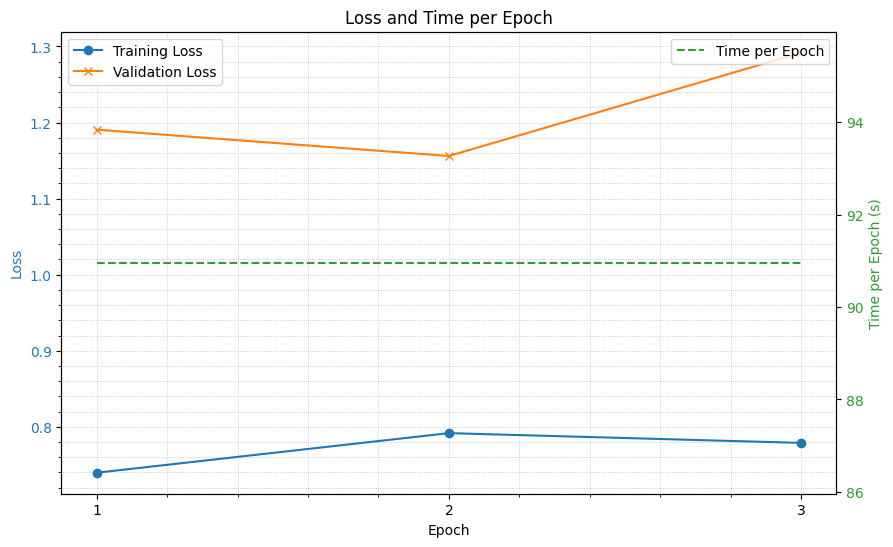

Total train images:      8116
Total validation images: 2319
Batch:                   64

Total time:              0:04:32.880375
Time per epoch:          0:01:30.960125
Time per item:           0:00:00.008717

Total epochs:            3
Best epoch               2

Training loss:           0.79166561
Validation loss:         1.15602183


In [9]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=EPOCHS,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

plot_loss_and_time(loss, val_loss, total_time)

with open(os.path.join(OUTPUT_PATH, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

# Predict

In [10]:

from src.data.preproc import adjust_to_see
import datetime

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(OUTPUT_PATH, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

Model Predict
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step
CTC Decode
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


# Evaluation

In [ ]:
from src.data.evaluation import ocr_metrics

# At this point, you already have your predictions and ground truth:
# predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
# ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

# Calculate metrics
cer, wer, ser, char_acc, word_acc, seq_acc = ocr_metrics(predicts, ground_truth)

# Print results
print(f"Character Error Rate: {cer:.4f}")
print(f"Word Error Rate:      {wer:.4f}")
print(f"Sequence Error Rate:  {ser:.4f}")
print(f"Character Accuracy:   {char_acc:.4f}")
print(f"Word Accuracy:        {word_acc:.4f}")
print(f"Sequence Accuracy:    {seq_acc:.4f}")

# Optionally, save to file
e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Character Error Rate: {cer:.8f}",
    f"Word Error Rate:      {wer:.8f}",
    f"Sequence Error Rate:  {ser:.8f}",
    f"Character Accuracy:   {char_acc:.8f}",
    f"Word Accuracy:        {word_acc:.8f}",
    f"Sequence Accuracy:    {seq_acc:.8f}"
])

with open(os.path.join(OUTPUT_PATH, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Character Error Rate: 0.0544
Word Error Rate:      0.2000
Sequence Error Rate:  0.2000
Character Accuracy:   0.9456
Word Accuracy:        0.8000
Sequence Accuracy:    0.8000
Total test images:    1160
Character Error Rate: 0.05438693
Word Error Rate:      0.20000000
Sequence Error Rate:  0.20000000
Character Accuracy:   0.94561307
Word Accuracy:        0.80000000
Sequence Accuracy:    0.80000000
